<a href="https://colab.research.google.com/github/JosephBaquerizo/dataset_turbina_jacket/blob/main/2_Prueba_Copy_SNN_Fisura%7CPernoflojo_Correci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importaciones

In [75]:
from google.colab import drive
from os import listdir
from os.path import isfile, join
from scipy.io import loadmat
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import random

import datetime
import os

## Obtención de Datos

In [76]:
# Establecemos conexión con Google Drive para acceder a la carpeta de datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# Guardamos la dirección de los datasets (experimentos) en una variable para utilizala posteriormente
dataset_datos_dir = 'drive/MyDrive/DATOS_EXPERIMENTALES_JACKET/DATOS'

In [78]:
# Obtenemos una lista con todos los nombres de los archivos relacionados a los experimentos realizados
dataset_datos_files = [dataset_datos_dir+'/'+filename for filename in listdir(dataset_datos_dir) if isfile(join(dataset_datos_dir, filename))]

In [79]:
# Creamos listas en donde se almacenarán los archivos relacionados a experimentos de fisura y experimentos de perno flojo respectivamente
datos_fisura = []
datos_pernoflojo = []

In [80]:
# Iteramos los nombres de todos los archivos en la lista general previamente creada
for filename in listdir(dataset_datos_dir):
  # Obtenemos el nombre del archivo tal cual, sin direcciones previas
  if isfile(join(dataset_datos_dir, filename)):
    nombre_archivo = filename.split('.')[0]
    # El estado de fisura se asocia al número 3 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_fisura
    if (nombre_archivo.split('_')[0] == '3'):
      datos_fisura.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '4'):
      datos_pernoflojo.append(dataset_datos_dir + '/' + filename)

## Datos Fisura

In [81]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_fisura = []
amplitud_experimentos_fisura = []

In [82]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_fisura:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_fisura creada anteriormente
  numero_experimentos_fisura.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_fisura creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_fisura.append(amplitud_experimento)
  else:
    amplitud_experimentos_fisura.append(int(amplitud_experimento))

In [83]:
# Creamos un DataFrame vacío
df_fisura = pd.DataFrame()

In [84]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_fisura)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_fisura[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_fisura[indice]
  df['amplitud'] = amplitud_experimentos_fisura[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_fisura = pd.concat([df_fisura, df], axis = 0)

In [85]:
# Revisamos el conjunto de datos obtenido para fisura
df_fisura.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000132,0.000185,0.000122,0.000105,0.000141,0.000075,0.000007,0.000231,0.000299,0.000113,0.000228,0.000225,0.000168,0.000018,0.000344,0.000275,-0.000017,0.000046,0.000200,0.000169,0.000097,0.000196,-0.000053,0.000018,1,1.0
1,0.000092,0.000223,0.000166,0.000127,0.000191,0.000137,0.000075,0.000192,0.000240,0.000095,0.000279,0.000231,0.000145,0.000037,0.000339,0.000092,0.000085,0.000074,0.000128,0.000163,0.000074,0.000085,0.000063,-0.000027,1,1.0
2,0.000091,0.000280,0.000188,0.000130,0.000172,0.000102,0.000161,0.000158,0.000211,0.000123,0.000269,0.000206,0.000198,0.000041,0.000312,0.000179,0.000011,0.000079,0.000117,0.000146,0.000085,0.000089,-0.000014,0.000020,1,1.0
3,0.000179,0.000199,0.000249,0.000102,0.000268,0.000140,0.000126,0.000231,0.000239,0.000102,0.000284,0.000175,0.000164,0.000082,0.000311,0.000235,0.000031,0.000079,0.000257,0.000110,0.000050,0.000120,0.000080,0.000057,1,1.0
4,0.000282,0.000277,0.000202,0.000211,0.000251,0.000159,0.000096,0.000205,0.000342,0.000113,0.000240,0.000272,0.000214,0.000057,0.000304,0.000302,0.000047,0.000150,0.000271,0.000168,0.000126,0.000224,0.000105,0.000058,1,1.0
5,0.000005,0.000196,0.000247,0.000109,0.000186,0.000115,0.000042,0.000129,0.000255,0.000108,0.000315,0.000214,0.000237,-0.000001,0.000334,0.000202,-0.000008,0.000081,0.000173,0.000165,0.000126,0.000107,-0.000012,0.000006,1,1.0
6,0.000176,0.000372,0.000223,0.000154,0.000258,0.000165,0.000170,0.000157,0.000228,0.000126,0.000282,0.000219,0.000198,0.000081,0.000333,0.000146,0.000065,0.000070,0.000140,0.000145,0.000099,0.000115,0.000068,-0.000031,1,1.0
7,0.000133,0.000171,0.000187,0.000182,0.000237,0.000159,0.000121,0.000280,0.000293,0.000096,0.000248,0.000202,0.000160,0.000015,0.000319,0.000335,-0.000004,0.000102,0.000201,0.000193,0.000180,0.000171,-0.000009,0.000095,1,1.0


In [86]:
# Si dividimos para 99097 el df_fisura deberíamos obtener 20 experimentos en total
len(df_fisura)/99097

20.0

In [87]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_fisura = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_fisura["#_exp"] == i
    filter2 = df_fisura["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_fisura.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_fisura.append(arreglo_matrices_asociadas)

In [88]:
len(arreglo_imagenes_por_experimento_fisura)

20

In [89]:
len(arreglo_imagenes_por_experimento_fisura[0])

24

In [90]:
len(arreglo_imagenes_por_experimento_fisura[0][0])

64

In [91]:
arreglo_imagenes_por_experimento_fisura[0][0][0].size

256

In [92]:
arreglo_imagenes_por_experimento_fisura[0][0][0].shape

(16, 16)

In [93]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_fisura = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento in arreglo_imagenes_por_experimento_fisura:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_fisura.append(np.array(imagen))

In [94]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_fisura)

1280

In [95]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_fisura = randint(0, len(arreglo_imagenes_fisura) - 1)
arreglo_imagenes_fisura[indice_imagen_fisura].shape, type(arreglo_imagenes_fisura[0]), indice_imagen_fisura

((24, 16, 16), numpy.ndarray, 432)

In [96]:
imagenes_fisura_05 = []
imagenes_fisura_1 = []
imagenes_fisura_2 = []
imagenes_fisura_3 = []

In [97]:
lista_indices = [0]
indice_contador = 0

while indice_contador < 1280:
  indice_contador = indice_contador + 64
  lista_indices.append(indice_contador)
print(lista_indices)

[0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280]


In [98]:
# indices paa fisura, pernoflojo y replica
indices_05 = [1, 5, 9, 13, 17]
indices_1 = [2, 6, 10, 14, 18]
indices_2 = [3, 7, 11, 15, 19]
indices_3 = [4, 8, 12, 16, 20]

In [99]:
for i in indices_05:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_3.append(j)

In [100]:
len(imagenes_fisura_05), len(imagenes_fisura_1), len(imagenes_fisura_2), len(imagenes_fisura_3)

(320, 320, 320, 320)

## Datos Perno Flojo

In [101]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_pernoflojo = []
amplitud_experimentos_pernoflojo = []

In [102]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_pernoflojo:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_pernoflojo creada anteriormente
  numero_experimentos_pernoflojo.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_pernoflojo creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_pernoflojo.append(amplitud_experimento)
  else:
    amplitud_experimentos_pernoflojo.append(int(amplitud_experimento))

In [103]:
# Creamos un DataFrame vacío
df_pernoflojo = pd.DataFrame()

In [104]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_pernoflojo)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_pernoflojo[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_pernoflojo[indice]
  df['amplitud'] = amplitud_experimentos_pernoflojo[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_pernoflojo = pd.concat([df_pernoflojo, df], axis = 0)

In [105]:
# Revisamos el conjunto de datos obtenido para pernoflojo
df_pernoflojo.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000168,0.000204,0.000213,0.000135,0.000201,0.000099,0.000108,0.000189,0.000212,0.000093,0.000257,0.000196,0.000173,0.000029,0.000316,0.000202,0.000010,0.000085,0.000151,0.000136,0.000116,0.000099,0.000054,0.000111,1,0.5
1,0.000122,0.000277,0.000213,0.000180,0.000230,0.000172,0.000068,0.000213,0.000214,0.000095,0.000272,0.000172,0.000173,0.000050,0.000292,0.000178,0.000021,0.000022,0.000203,0.000139,0.000076,0.000164,0.000089,0.000076,1,0.5
2,0.000099,0.000214,0.000128,0.000153,0.000217,0.000100,0.000064,0.000174,0.000225,0.000116,0.000245,0.000202,0.000140,0.000012,0.000309,0.000256,0.000023,0.000089,0.000225,0.000162,0.000098,0.000154,0.000091,0.000092,1,0.5
3,0.000150,0.000258,0.000209,0.000163,0.000213,0.000120,0.000066,0.000157,0.000220,0.000096,0.000229,0.000203,0.000157,0.000057,0.000292,0.000260,0.000062,0.000077,0.000212,0.000178,0.000123,0.000150,0.000056,0.000130,1,0.5
4,0.000194,0.000244,0.000194,0.000201,0.000202,0.000127,0.000133,0.000197,0.000212,0.000110,0.000266,0.000199,0.000181,0.000040,0.000336,0.000209,0.000092,0.000097,0.000183,0.000170,0.000114,0.000127,0.000064,0.000087,1,0.5
5,0.000156,0.000287,0.000188,0.000119,0.000234,0.000127,0.000102,0.000198,0.000216,0.000097,0.000280,0.000222,0.000140,0.000058,0.000296,0.000212,0.000061,0.000097,0.000231,0.000156,0.000090,0.000155,0.000076,0.000091,1,0.5
6,0.000150,0.000230,0.000198,0.000239,0.000247,0.000150,0.000052,0.000178,0.000255,0.000115,0.000235,0.000189,0.000216,0.000072,0.000299,0.000233,0.000060,0.000124,0.000225,0.000157,0.000133,0.000153,0.000060,0.000087,1,0.5
7,0.000130,0.000230,0.000207,0.000116,0.000212,0.000108,0.000096,0.000178,0.000200,0.000130,0.000260,0.000203,0.000216,0.000057,0.000329,0.000261,0.000031,0.000045,0.000236,0.000178,0.000081,0.000160,0.000079,0.000115,1,0.5


In [106]:
# Si dividimos para 99097 el df_pernoflojo deberíamos obtener 20 experimentos en total
len(df_pernoflojo)/99097

20.0

In [107]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_pernoflojo = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_pernoflojo["#_exp"] == i
    filter2 = df_pernoflojo["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_pernoflojo.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_pernoflojo.append(arreglo_matrices_asociadas)

In [108]:
len(arreglo_imagenes_por_experimento_pernoflojo)

20

In [109]:
len(arreglo_imagenes_por_experimento_pernoflojo[0])

24

In [110]:
len(arreglo_imagenes_por_experimento_pernoflojo[0][0])

64

In [111]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].size

256

In [112]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].shape

(16, 16)

In [113]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_pernoflojo = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento_i in arreglo_imagenes_por_experimento_pernoflojo:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento_i:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_pernoflojo.append(np.array(imagen))

In [114]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_pernoflojo)

1280

In [115]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_pernoflojo = randint(0, len(arreglo_imagenes_pernoflojo) - 1)
arreglo_imagenes_pernoflojo[indice_imagen_pernoflojo].shape, type(arreglo_imagenes_pernoflojo[0]), indice_imagen_pernoflojo

((24, 16, 16), numpy.ndarray, 99)

In [116]:
imagenes_pernoflojo_05 = []
imagenes_pernoflojo_1 = []
imagenes_pernoflojo_2 = []
imagenes_pernoflojo_3 = []

In [117]:
for i in indices_05:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_3.append(j)

In [118]:
len(imagenes_pernoflojo_05), len(imagenes_pernoflojo_1), len(imagenes_pernoflojo_2), len(imagenes_pernoflojo_3)

(320, 320, 320, 320)

## Aleatorizar

In [119]:
np.random.seed(300)

aleatorizadas_imagenes_fisura_05 = imagenes_fisura_05
aleatorizadas_imagenes_fisura_1 = imagenes_fisura_1
aleatorizadas_imagenes_fisura_2 = imagenes_fisura_2
aleatorizadas_imagenes_fisura_3 = imagenes_fisura_3

aleatorizadas_imagenes_pernoflojo_05 = imagenes_pernoflojo_05
aleatorizadas_imagenes_pernoflojo_1 = imagenes_pernoflojo_1
aleatorizadas_imagenes_pernoflojo_2 = imagenes_pernoflojo_2
aleatorizadas_imagenes_pernoflojo_3 = imagenes_pernoflojo_3

np.random.shuffle(aleatorizadas_imagenes_fisura_05)
np.random.shuffle(aleatorizadas_imagenes_fisura_1)
np.random.shuffle(aleatorizadas_imagenes_fisura_2)
np.random.shuffle(aleatorizadas_imagenes_fisura_3)

np.random.shuffle(aleatorizadas_imagenes_pernoflojo_05)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_1)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_2)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_3)

In [120]:
lista_listas_imagenes_fisura = [aleatorizadas_imagenes_fisura_05, aleatorizadas_imagenes_fisura_1, aleatorizadas_imagenes_fisura_2, aleatorizadas_imagenes_fisura_3]
lista_listas_imagenes_pernoflojo = [aleatorizadas_imagenes_pernoflojo_05, aleatorizadas_imagenes_pernoflojo_1, aleatorizadas_imagenes_pernoflojo_2, aleatorizadas_imagenes_pernoflojo_3]

## Segmentar datos en entrenamiento, validación y prueba

In [121]:
porcentaje_80 = int(320*0.8)
porcentaje_10 = int(320*0.1)
porcentaje_15 = int(320*0.15)
porcentaje_70 = int(320*0.7)

In [122]:
# Para 80 10 10 
conjunto_entrenamiento_fisura_1 = []
conjunto_validacion_fisura_1 = []
conjunto_prueba_fisura_1 = []

conjunto_entrenamiento_pernoflojo_1 = []
conjunto_validacion_pernoflojo_1 = []
conjunto_prueba_pernoflojo_1 = []

# Para 80 15 5
conjunto_entrenamiento_fisura_2 = []
conjunto_validacion_fisura_2 = []
conjunto_prueba_fisura_2 = []

conjunto_entrenamiento_pernoflojo_2 = []
conjunto_validacion_pernoflojo_2 = []
conjunto_prueba_pernoflojo_2 = []

# Para 70 15 15
conjunto_entrenamiento_fisura_3 = []
conjunto_validacion_fisura_3 = []
conjunto_prueba_fisura_3 = []

conjunto_entrenamiento_pernoflojo_3 = []
conjunto_validacion_pernoflojo_3 = []
conjunto_prueba_pernoflojo_3 = []

In [123]:
# Para 80 10 10
for lista in lista_listas_imagenes_fisura:
  for imagen_entrenamiento in lista[:porcentaje_80]:
    conjunto_entrenamiento_fisura_1.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_80:porcentaje_80 + porcentaje_10]:
    conjunto_validacion_fisura_1.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_80 + porcentaje_10:]:
    conjunto_prueba_fisura_1.append(imagen_prueba)

for lista in lista_listas_imagenes_pernoflojo:
  for imagen_entrenamiento in lista[:porcentaje_80]:
    conjunto_entrenamiento_pernoflojo_1.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_80:porcentaje_80 + porcentaje_10]:
    conjunto_validacion_pernoflojo_1.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_80 + porcentaje_10:]:
    conjunto_prueba_pernoflojo_1.append(imagen_prueba)

In [124]:
# Para 80 15 5
for lista in lista_listas_imagenes_fisura:
  for imagen_entrenamiento in lista[:porcentaje_80]:
    conjunto_entrenamiento_fisura_2.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_80:porcentaje_80 + porcentaje_15]:
    conjunto_validacion_fisura_2.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_80 + porcentaje_15:]:
    conjunto_prueba_fisura_2.append(imagen_prueba)

for lista in lista_listas_imagenes_pernoflojo:
  for imagen_entrenamiento in lista[:porcentaje_80]:
    conjunto_entrenamiento_pernoflojo_2.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_80:porcentaje_80 + porcentaje_15]:
    conjunto_validacion_pernoflojo_2.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_80 + porcentaje_15:]:
    conjunto_prueba_pernoflojo_2.append(imagen_prueba)

In [125]:
# Para 70 15 15
for lista in lista_listas_imagenes_fisura:
  for imagen_entrenamiento in lista[:porcentaje_70]:
    conjunto_entrenamiento_fisura_3.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_70:porcentaje_70 + porcentaje_15]:
    conjunto_validacion_fisura_3.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_70 + porcentaje_15:]:
    conjunto_prueba_fisura_3.append(imagen_prueba)

for lista in lista_listas_imagenes_pernoflojo:
  for imagen_entrenamiento in lista[:porcentaje_70]:
    conjunto_entrenamiento_pernoflojo_3.append(imagen_entrenamiento)
  for imagen_validacion in lista[porcentaje_70:porcentaje_70 + porcentaje_15]:
    conjunto_validacion_pernoflojo_3.append(imagen_validacion)
  for imagen_prueba in lista[porcentaje_70 + porcentaje_15:]:
    conjunto_prueba_pernoflojo_3.append(imagen_prueba)

## Red Neuronal Siamesa

In [126]:
def crear_pares(arreglo_imagenes_fisura, arreglo_imagenes_pernoflojo):
  """
  Función empleada para crear los pares de imágenes que se utilizan
  para el entrenamiento de la SNN.
  """
  print("Creando pares...")
  # Creamos arreglo en donde se insertarán los pares (positivos y negativos)
  pares_img = []
  # Creamos arreglo en donde se insertarán la clasificación de los pares (similares = 1, no similares = 0)
  pares_label = []

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_fisura in arreglo_imagenes_fisura:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (fisura)
    imagen_positiva_fisura = random.choice(arreglo_imagenes_fisura)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (perno flojo)
    imagen_negativa_fisura = random.choice(arreglo_imagenes_pernoflojo)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_fisura, imagen_positiva_fisura])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_fisura, imagen_negativa_fisura])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_pernoflojo in arreglo_imagenes_pernoflojo:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (perno flojo)
    imagen_positiva_pernoflojo = random.choice(arreglo_imagenes_pernoflojo)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (fisura)
    imagen_negativa_pernoflojo = random.choice(arreglo_imagenes_fisura)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_pernoflojo, imagen_positiva_pernoflojo])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_pernoflojo, imagen_negativa_pernoflojo])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])
  
  print("Pares creados.")

  return (np.array(pares_img), np.array(pares_label))

## SNN

In [127]:
def euclidean_distance(vectors):
  
  # Descomprimimos los vectores en listas separadas
  (featsA, featsB) = vectors

  # Realizamos la suma de las diferenias cuadradas entre vectores
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)

  # Retornamos la distancia euclidiana
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [128]:
# Definimos función de visualización de pérdidas

def graficar_curva_perdidas(history):
  """
  Función utilizada para visualizar la historia de nuestro modelo.
  Incluye pérdidas y precisión a lo largo de cada iteración.
  """
  # Obtenemos las pérdidas de los conjuntos de entrenamiento y validación
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Obtenemos la precisión de los conjuntos de entrenamiento y validación
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Determinamos las iteraciones que hubo durante el entrenamiento
  epochs = range(len(history.history['loss']))

  # Graficamos las pérdidas de ambos conjuntos a lo largo de las iteraciones
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Graficamos la precisión de ambos conjuntos a lo largo de las iteraciones
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

Modelo Experimental #1

- entrenamiento = 80%

- validación = 10%

- prueba = 10%

In [129]:
(pares_m1_entrenamiento, labels_m1_entrenamiento) = crear_pares(conjunto_entrenamiento_fisura_1, conjunto_entrenamiento_pernoflojo_1)
(pares_m1_validacion, labels_m1_validacion) = crear_pares(conjunto_validacion_fisura_1, conjunto_validacion_pernoflojo_1)
(pares_m1_prueba, labels_m1_prueba) = crear_pares(conjunto_prueba_fisura_1, conjunto_prueba_pernoflojo_1)

Creando pares...
Pares creados.
Creando pares...
Pares creados.
Creando pares...
Pares creados.


In [130]:
np.random.seed(300)

pares_aleatorizados_m1 = pares_m1_entrenamiento
np.random.shuffle(pares_aleatorizados_m1)

In [131]:
np.random.seed(300)

labels_aleatorizados_m1 = labels_m1_entrenamiento
np.random.shuffle(labels_aleatorizados_m1)

In [132]:
# Creamos función que retorna la estructura de la red convolucional que se va a utilizar
def build_siamese_model_1(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=10,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=7,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=256,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(4960)
  ])

  return model

In [133]:
tf.random.set_seed(100)

# Creamos el modelo general
IMG_SHAPE = (24, 16, 16)

# Definimos los inputs (imágenes) que ingresan a cada CNN
imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

# Creamos el featureExtractor, el cual obtiene las características principales de las imágenes ingresadas y las muestra en un vector
featureExtractor = build_siamese_model_1(input_shape=IMG_SHAPE)

# Ingresamos cada imagen al featureExtractor
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Creamos una capa Lambda (que aplica una función sobre los datos) para obtener la distancia euclidiana
distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

# Creamos la última capa asociada a la función de activación sigmoide
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

# Establecemos el modelo general
model_1 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

# Empleamos el loss como binary_crossentropy porque solo queremos saber si las imágenes son similares o no (no queremos clasificarlas)
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                metrics=['accuracy'])

# Hacemos el fit del modelo
history_1 = model_1.fit(
    [pares_aleatorizados_m1[:, 0], pares_aleatorizados_m1[:, 1]], labels_aleatorizados_m1[:],
     validation_data=([pares_m1_validacion[:, 0], pares_m1_validacion[:, 1]], labels_m1_validacion[:]),
     batch_size=32,
     epochs=10
)

Epoch 1/10
128/128 [==============================] - 78s 607ms/step - loss: 0.6231 - accuracy: 0.5432 - val_loss: 0.4445 - val_accuracy: 0.7617
Epoch 2/10
128/128 [==============================] - 77s 602ms/step - loss: 0.3809 - accuracy: 0.8462 - val_loss: 0.3230 - val_accuracy: 0.9609
Epoch 3/10
128/128 [==============================] - 77s 600ms/step - loss: 0.2509 - accuracy: 0.9548 - val_loss: 0.2581 - val_accuracy: 0.9277
Epoch 4/10
128/128 [==============================] - 77s 601ms/step - loss: 0.1837 - accuracy: 0.9802 - val_loss: 0.1904 - val_accuracy: 0.9961
Epoch 5/10
128/128 [==============================] - 77s 602ms/step - loss: 0.1239 - accuracy: 0.9937 - val_loss: 0.1407 - val_accuracy: 0.9766
Epoch 6/10
128/128 [==============================] - 77s 602ms/step - loss: 0.0882 - accuracy: 0.9985 - val_loss: 0.1118 - val_accuracy: 0.9824
Epoch 7/10
128/128 [==============================] - 80s 622ms/step - loss: 0.0674 - accuracy: 0.9995 - val_loss: 0.0915 - val_ac

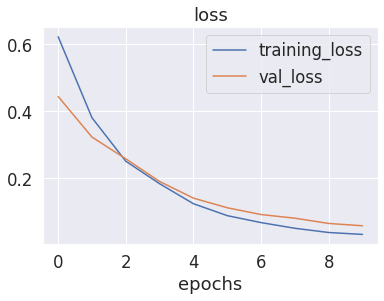

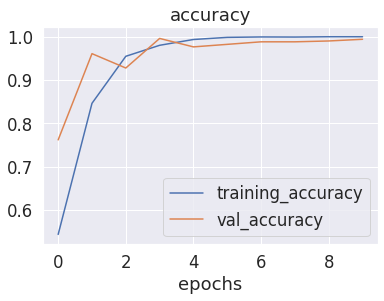

In [134]:
graficar_curva_perdidas(history_1)

Modelo Experimental #2

- entrenamiento = 80%

- validación = 15%

- prueba = 5%

In [135]:
(pares_m2_entrenamiento, labels_m2_entrenamiento) = crear_pares(conjunto_entrenamiento_fisura_2, conjunto_entrenamiento_pernoflojo_2)
(pares_m2_validacion, labels_m2_validacion) = crear_pares(conjunto_validacion_fisura_2, conjunto_validacion_pernoflojo_2)
(pares_m2_prueba, labels_m2_prueba) = crear_pares(conjunto_prueba_fisura_2, conjunto_prueba_pernoflojo_2)

Creando pares...
Pares creados.
Creando pares...
Pares creados.
Creando pares...
Pares creados.


In [136]:
np.random.seed(300)

pares_aleatorizados_m2 = pares_m2_entrenamiento
np.random.shuffle(pares_aleatorizados_m2)

In [137]:
np.random.seed(300)

labels_aleatorizados_m2 = labels_m2_entrenamiento
np.random.shuffle(labels_aleatorizados_m2)

In [138]:
# Creamos función que retorna la estructura de la red convolucional que se va a utilizar
def build_siamese_model_2(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=10,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=7,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=256,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(4960)
  ])

  return model

In [139]:
tf.random.set_seed(100)

IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_2(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_2 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                metrics=['accuracy'])

history_2 = model_2.fit(
    [pares_aleatorizados_m2[:, 0], pares_aleatorizados_m2[:, 1]], labels_aleatorizados_m2[:],
     validation_data=([pares_m2_validacion[:, 0], pares_m2_validacion[:, 1]], labels_m2_validacion[:]),
     batch_size=32,
     epochs=10
)

Epoch 1/10
128/128 [==============================] - 80s 623ms/step - loss: 0.5959 - accuracy: 0.5864 - val_loss: 0.4336 - val_accuracy: 0.7826
Epoch 2/10
128/128 [==============================] - 80s 629ms/step - loss: 0.3552 - accuracy: 0.8787 - val_loss: 0.3114 - val_accuracy: 0.9206
Epoch 3/10
128/128 [==============================] - 81s 629ms/step - loss: 0.2266 - accuracy: 0.9685 - val_loss: 0.2207 - val_accuracy: 0.9466
Epoch 4/10
128/128 [==============================] - 81s 630ms/step - loss: 0.1570 - accuracy: 0.9924 - val_loss: 0.1799 - val_accuracy: 0.9674
Epoch 5/10
128/128 [==============================] - 81s 630ms/step - loss: 0.1136 - accuracy: 0.9988 - val_loss: 0.1621 - val_accuracy: 0.9661
Epoch 6/10
128/128 [==============================] - 81s 629ms/step - loss: 0.0822 - accuracy: 0.9990 - val_loss: 0.1166 - val_accuracy: 0.9883
Epoch 7/10
128/128 [==============================] - 81s 630ms/step - loss: 0.0623 - accuracy: 0.9995 - val_loss: 0.0785 - val_ac

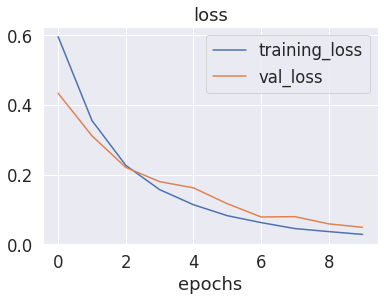

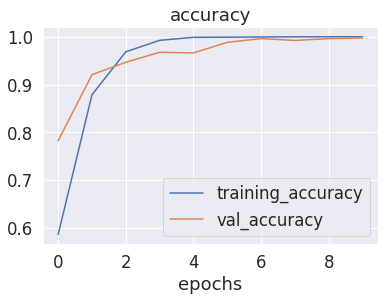

In [140]:
graficar_curva_perdidas(history_2)


Modelo Experimental #3

- entrenamiento = 70%

- validación = 15%

- prueba = 15%

In [141]:
(pares_m3_entrenamiento, labels_m3_entrenamiento) = crear_pares(conjunto_entrenamiento_fisura_3, conjunto_entrenamiento_pernoflojo_3)
(pares_m3_validacion, labels_m3_validacion) = crear_pares(conjunto_validacion_fisura_3, conjunto_validacion_pernoflojo_3)
(pares_m3_prueba, labels_m3_prueba) = crear_pares(conjunto_prueba_fisura_3, conjunto_prueba_pernoflojo_3)

Creando pares...
Pares creados.
Creando pares...
Pares creados.
Creando pares...
Pares creados.


In [142]:
np.random.seed(300)

pares_aleatorizados_m3 = pares_m3_entrenamiento
np.random.shuffle(pares_aleatorizados_m3)

In [143]:
np.random.seed(300)

labels_aleatorizados_m3 = labels_m3_entrenamiento
np.random.shuffle(labels_aleatorizados_m3)

In [145]:
def build_siamese_model_3(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=10,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=7,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=256,
                                                        kernel_size=4,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(4960)
  ])

  return model

In [146]:
tf.random.set_seed(100)

IMG_SHAPE = (24, 16, 16)

imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

featureExtractor = build_siamese_model_3(input_shape=IMG_SHAPE)

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

model_3 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                metrics=['accuracy'])

history_3 = model_3.fit(
    [pares_aleatorizados_m3[:, 0], pares_aleatorizados_m3[:, 1]], labels_aleatorizados_m3[:],
     validation_data=([pares_m3_validacion[:, 0], pares_m3_validacion[:, 1]], labels_m3_validacion[:]),
     batch_size=32,
     epochs=10
)

Epoch 1/10
112/112 [==============================] - 71s 632ms/step - loss: 0.6933 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
112/112 [==============================] - 70s 623ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
112/112 [==============================] - 70s 623ms/step - loss: 0.6933 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
112/112 [==============================] - 70s 622ms/step - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
112/112 [==============================] - 70s 621ms/step - loss: 0.6934 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
112/112 [==============================] - 70s 622ms/step - loss: 0.6933 - accuracy: 0.4849 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
112/112 [==============================] - 70s 622ms/step - loss: 0.6933 - accuracy: 0.4883 - val_loss: 0.6931 - val_ac

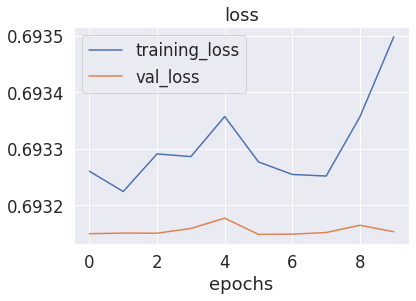

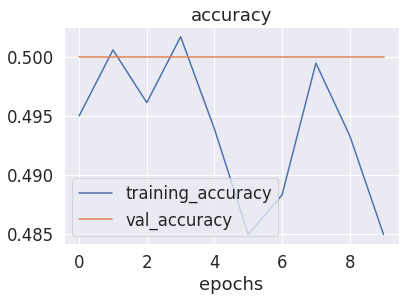

In [147]:
graficar_curva_perdidas(history_3)

## Matriz de confusión

In [148]:
# Creamos una función que nos permita visualizar la matriz de confusión de los resultados
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt='g')
    plt.xlabel('Label Reales')
    plt.ylabel('Predicciones')

In [150]:
# Guardamos las predicciones en una variable
predicciones_1 = model_1.predict([pares_m1_prueba[:, 0], pares_m1_prueba[:, 1]])

In [151]:
# Redondeamos los valores predecidos para poder compararlos con los valores reales
for i in range(len(predicciones_1)):
  predicciones_1[i][0] = round(predicciones_1[i][0])

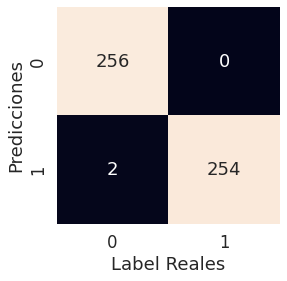

In [153]:
# Graficamos la matriz de confusión
plot_conf_mat(labels_m1_prueba, predicciones_1)

In [154]:
# Guardamos las predicciones en una variable
predicciones_2 = model_2.predict([pares_m2_prueba[:, 0], pares_m2_prueba[:, 1]])

In [155]:
# Redondeamos los valores predecidos para poder compararlos con los valores reales
for i in range(len(predicciones_2)):
  predicciones_2[i][0] = round(predicciones_2[i][0])

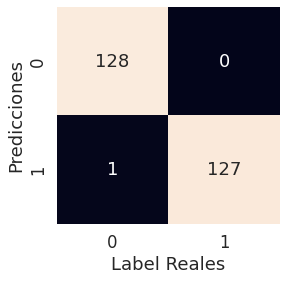

In [156]:
# Graficamos la matriz de confusión
plot_conf_mat(labels_m2_prueba, predicciones_2)

In [157]:
# Guardamos las predicciones en una variable
predicciones_3 = model_3.predict([pares_m3_prueba[:, 0], pares_m3_prueba[:, 1]])

In [158]:
# Redondeamos los valores predecidos para poder compararlos con los valores reales
for i in range(len(predicciones_3)):
  predicciones_3[i][0] = round(predicciones_3[i][0])

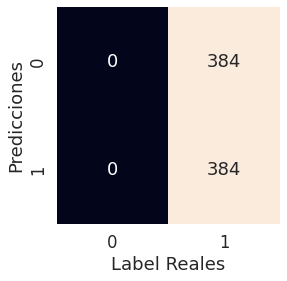

In [159]:
# Graficamos la matriz de confusión
plot_conf_mat(labels_m3_prueba, predicciones_3)